In [1]:
import jax
import jax.numpy as jnp
from evosax import ParameterReshaper
import ipyplot
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Setup

### Create environment

In [2]:
import gymnax as gym

In [3]:
env_name = "MountainCar-v0"
env, env_params = gym.make(env_name)
n_actions = env.action_space(env_params).n
obs_dims = env.observation_space(env_params).shape[0]

In [4]:
env_steps = env_params.max_steps_in_episode

### Create NDP and Policy

In [5]:
from models import HyperNCA, HyperNCA_Config
from policies import MLPPolicy

In [6]:
# MLP configuration
mlp_hidden_dims = max((obs_dims, n_actions)) # nb of features for each hidden layer
mlp_hidden_layers = 1 # nb of hidden layers
mlp_action_dims = n_actions 
mlp_obs_dims = obs_dims

In [7]:
policy = MLPPolicy(mlp_action_dims, mlp_hidden_layers,
                  mlp_hidden_dims, mode="categorical")
key = jax.random.PRNGKey(42)
policy_params = policy.init(key, jnp.zeros((obs_dims,)), key)
policy_params

FrozenDict({
    params: {
        mlp: {
            layers_0: {
                kernel: Array([[-0.0854697 , -0.42540255, -0.10164906],
                       [-0.11355377,  0.05332496, -1.1430653 ]], dtype=float32),
            },
            out_layer: {
                kernel: Array([[-0.68307227,  0.38337517, -0.16882634],
                       [-0.7283222 , -0.1463625 , -0.5922689 ],
                       [-0.16727802, -1.1538497 , -0.2005003 ]], dtype=float32),
            },
        },
    },
})

In [8]:
# NCA Configuration
channels = 4
alpha = 0.1 # alive threshold
perception_dims = 3 # nb of perception kernels
update_features = (16,) # hidden features of update network

iterations = 20 #number of development steps

In [9]:
ndp_config = HyperNCA_Config(
    channels = channels,
    alpha = alpha,
    perception_dims = perception_dims,
    update_features = update_features,
    iterations = iterations,
    action_dims = n_actions,
    obs_dims = obs_dims,
    hidden_dims = mlp_hidden_dims,
    hidden_layers = mlp_hidden_layers
)

In [10]:
ndp = HyperNCA(ndp_config)

In [11]:
z_dims = ndp.z_dims # nb of dimensions of the latent space (channels)
z_dims

4

In [12]:
ndp_params = ndp.init(jax.random.PRNGKey(42), jnp.ones((z_dims, )))
parameter_reshaper = ParameterReshaper(ndp_params)

ParameterReshaper: 580 parameters detected for optimization.


### Create evaluator

In [13]:
from evaluators import CompoDivEvaluator, CompoDivEvaluator_Config
from envs import bd_mountain_car

In [14]:
evaluator_config = CompoDivEvaluator_Config(
    epochs = 3,
    env = env,
    env_params = env_params,
    env_steps = 200,
    n_params = z_dims,
    bd_extractor = bd_mountain_car,
    popsize = 60
)

In [15]:
evaluator = CompoDivEvaluator(evaluator_config, ndp, policy)

### Create Trainer

In [16]:
from metandp import NDP_Trainer, Config

In [17]:
trainer_config = Config(
    epochs = 200,
    n_params = parameter_reshaper.total_params,
    params_shaper = parameter_reshaper,
    es = "des",
    popsize = 64,
    es_config = {},
    es_params = None
)

In [18]:
ndp_trainer = NDP_Trainer(trainer_config, ndp, evaluator)

# Train

In [19]:
key = jax.random.PRNGKey(42)
es_state, data = ndp_trainer.train(key)

	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #0 : avg = 0.17498156428337097, top = 0.27012354135513306, best = -0.27012354135513306
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #1 : avg = 0.16684532165527344, top = 0.25901830196380615, best = -0.27012354135513306
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #2 : avg = 0.16998004913330078, top = 0.31191956996917725, best = -0.31191956996917725
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #3 : avg = 0.1663079708814621, top = 0.2597321569919586, best = -0.31191956996917725
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #4 : avg = 0.17241057753562927, top = 0.2638337016105652, best = -0.31191956996917725
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #5 : avg = 0.17695531249046326, top = 0.26296675205230713, best = -0.31191956996917725
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #6 : avg = 0.1858048141002655, top = 0.4168734550476074, best = -0.4168734550476074
	INNE

	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #59 : avg = 0.7750672101974487, top = 1.0912785530090332, best = -1.1173022985458374
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #60 : avg = 0.7748937606811523, top = 1.0903524160385132, best = -1.1173022985458374
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #61 : avg = 0.7519681453704834, top = 1.1403789520263672, best = -1.1403789520263672
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #62 : avg = 0.7620961666107178, top = 1.0790672302246094, best = -1.1403789520263672
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #63 : avg = 0.7590302228927612, top = 1.061363935470581, best = -1.1403789520263672
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #64 : avg = 0.7012715339660645, top = 1.027878999710083, best = -1.1403789520263672
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #65 : avg = 0.7463756799697876, top = 1.0367047786712646, best = -1.1403789520263672
	INNER LOOP #0


	INNER LOOP #2
OUTER LOOP #117 : avg = 0.8287004232406616, top = 1.0592687129974365, best = -1.1667979955673218
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #118 : avg = 0.8505308628082275, top = 1.065622091293335, best = -1.1667979955673218
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #119 : avg = 0.7902138829231262, top = 1.1361935138702393, best = -1.1667979955673218
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #120 : avg = 0.8255558013916016, top = 1.0923328399658203, best = -1.1667979955673218
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #121 : avg = 0.8631764650344849, top = 1.1247117519378662, best = -1.1667979955673218
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #122 : avg = 0.8295257687568665, top = 1.1443151235580444, best = -1.1667979955673218
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #123 : avg = 0.839902400970459, top = 1.077420711517334, best = -1.1667979955673218
	INNER LOOP #0
	INNER LOOP #1
	INNER LO

	INNER LOOP #2
OUTER LOOP #175 : avg = 0.9802836775779724, top = 1.1199688911437988, best = -1.1739978790283203
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #176 : avg = 0.9469617605209351, top = 1.170507788658142, best = -1.1739978790283203
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #177 : avg = 0.9401159286499023, top = 1.1305067539215088, best = -1.1739978790283203
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #178 : avg = 0.9265703558921814, top = 1.0914015769958496, best = -1.1739978790283203
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #179 : avg = 0.9745487570762634, top = 1.1104152202606201, best = -1.1739978790283203
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #180 : avg = 0.943587064743042, top = 1.1011699438095093, best = -1.1739978790283203
	INNER LOOP #0
	INNER LOOP #1
	INNER LOOP #2
OUTER LOOP #181 : avg = 0.9572395086288452, top = 1.1711459159851074, best = -1.1739978790283203
	INNER LOOP #0
	INNER LOOP #1
	INNER L

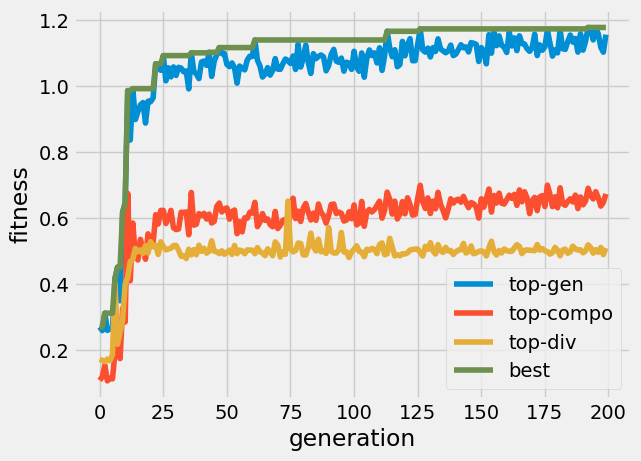

In [20]:
fitness = data['fitness']
compo = jnp.mean(data["eval_data"]["compo"], axis=-1)
div = jnp.mean(data["eval_data"]["div"]*30., axis=-1)
max_fitness = jnp.max(fitness, axis=-1)
top_compo = jnp.max(compo, axis=-1)
top_div = jnp.max(div, axis=-1)
best_fitness = -data['es_state'].best_fitness

plt.plot(max_fitness, label='top-gen')
plt.plot(top_compo, label='top-compo')
plt.plot(top_div, label='top-div')
plt.plot(best_fitness, label='best')
plt.legend()
plt.xlabel('generation')
plt.ylabel('fitness')
plt.show()

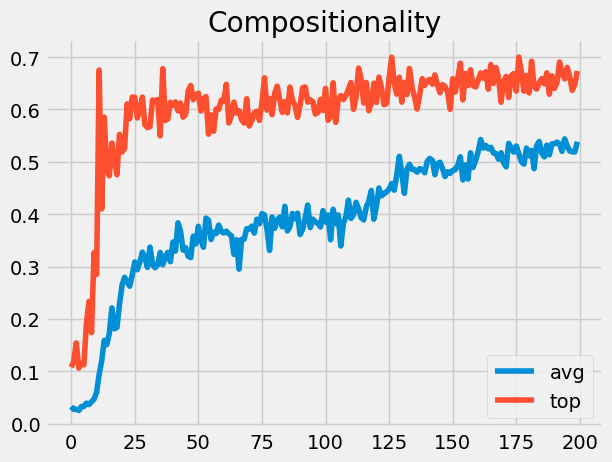

In [21]:
compo = jnp.mean(data["eval_data"]["compo"], axis=-1)
plt.plot(jnp.mean(compo, axis=-1), label="avg")
plt.plot(jnp.max(compo, axis=-1), label="top")
plt.legend()
plt.title('Compositionality')
plt.show()

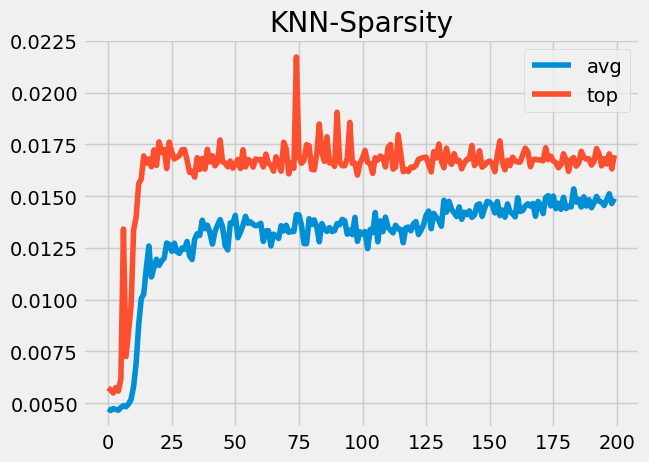

In [22]:
div = jnp.mean(data["eval_data"]["div"], axis=-1)
plt.plot(jnp.mean(div, axis=-1), label="avg")
plt.plot(jnp.max(div, axis=-1), label="top")
plt.legend()
plt.title('KNN-Sparsity')
plt.show()

In [23]:
best_params = es_state.best_member
best_params = parameter_reshaper.reshape(best_params[None, :])
best_params = jax.tree_map(lambda x: x[0], best_params)
test_key = jax.random.PRNGKey(60)
fit_best, best_test_data = evaluator.test(test_key, best_params, n_samples=1000)
fit_best

Array(0.5762017, dtype=float32)

In [24]:
bds_best = best_test_data['bd']

In [25]:
worst_params = data['es_state'].best_member[0]
worst_params = parameter_reshaper.reshape(worst_params[None, :])
worst_params = jax.tree_map(lambda x: x[0], worst_params)
test_key = jax.random.PRNGKey(66)
fit_worst, worst_test_data = evaluator.test(test_key, worst_params, n_samples=1000)
fit_worst

Array(0.0084253, dtype=float32)

In [26]:
bds_worst = worst_test_data['bd']

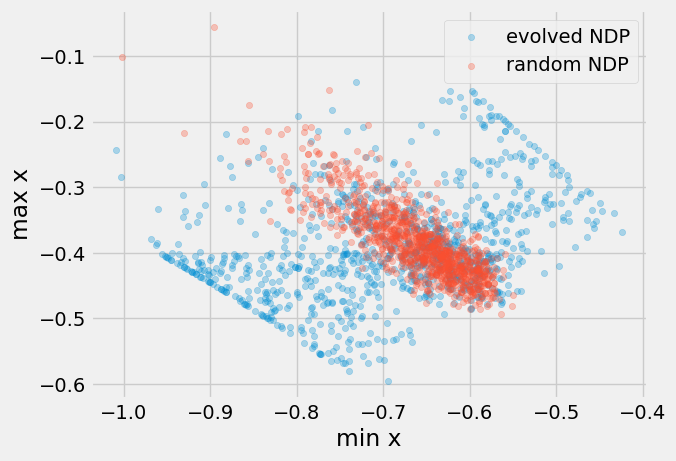

In [27]:
s=20.
plt.scatter(bds_best[:, 0], bds_best[:, 1], label='evolved NDP',
           alpha = .3, s=s)
plt.scatter(bds_worst[:, 0], bds_worst[:, 1], label='random NDP',
           alpha=.3, s=s)
plt.legend()
plt.xlabel('min x')
plt.ylabel('max x')
plt.show()

In [28]:
import pandas as pd
import seaborn as sns

In [29]:
data_best = pd.DataFrame()
data_best[["BC_1", "BC_2"]] = bds_best
data_best['NDP'] = "HyperNCA - evolved"

In [30]:
data_wrst = pd.DataFrame()
data_wrst[["BC_1", "BC_2"]] = bds_worst
data_wrst['NDP'] = "HyperNCA - random"

In [31]:
full_data = pd.concat([data_best, data_wrst])

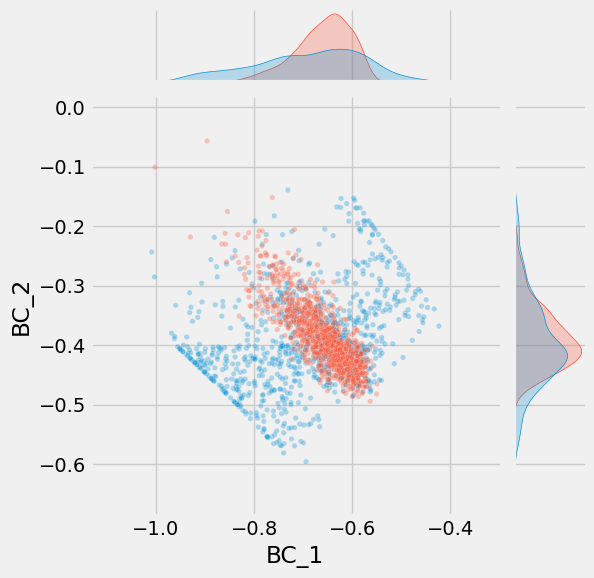

In [32]:
sns.jointplot(data=full_data, x="BC_1", y="BC_2", hue="NDP", kind='scatter',
             alpha = .3, s= 15., legend=False)

In [33]:
best_members = data['es_state'].best_member

### Evaluate compositionality

In [34]:
best_params = es_state.best_member
best_params = parameter_reshaper.reshape(best_params[None, :])
best_params = jax.tree_map(lambda x: x[0], best_params)
test_key = jax.random.PRNGKey(66)
score, test_data = evaluator.test(test_key, best_params, n_samples=10000)
score

Array(0.7232036, dtype=float32)

In [35]:
bd = test_data['bd']
z = test_data['z']
bd.shape, z.shape

((10000, 2), (10000, 4))

In [36]:
df = pd.DataFrame()
for dim in range(z_dims):
    df[f'z_{dim}'] = z[:, dim]
df['bd_0'] = bd[:, 0]
df['bd_1'] = bd[:, 1]

In [37]:
from sklearn.cross_decomposition import PLSSVD, PLSCanonical, PLSRegression, CCA
from sklearn.decomposition import PCA

In [38]:
n_components = 2
mod = PLSSVD(n_components=2)
bdr, zr = mod.fit_transform(bd, z)
if n_components == 1:
    df["zr"] = zr
    df["bdr"] = bdr
else :
    df[[f"zr{i}" for i in range(n_components)]] = zr
    df[[f"bdr{i}" for i in range(n_components)]] = bdr

<Axes: xlabel='zr0', ylabel='zr1'>

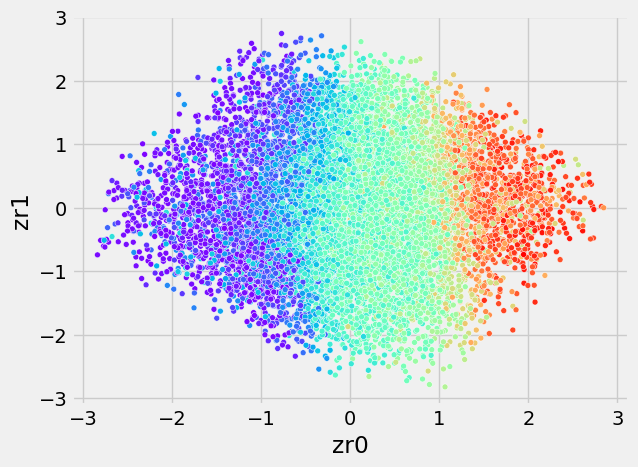

In [39]:
sns.scatterplot(data=df, x='zr0', y="zr1", hue="bdr0",
                legend=False, palette="rainbow", alpha=1., size=5.)

<Axes: xlabel='bd_0', ylabel='bd_1'>

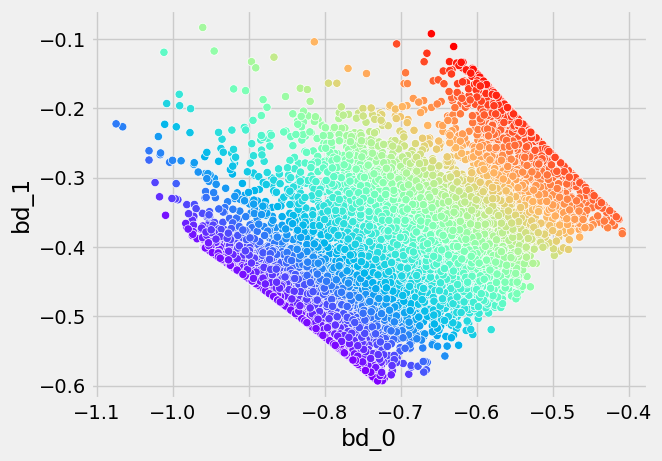

In [40]:
sns.scatterplot(data=df, x='bd_0', y="bd_1", hue="bdr0",
                legend=False, palette="rainbow")

<Axes: xlabel='bd_0', ylabel='bd_1'>

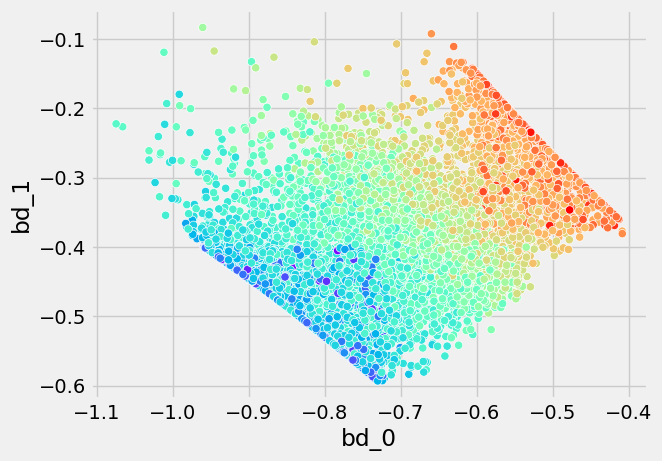

In [41]:
sns.scatterplot(data=df, x='bd_0', y="bd_1", hue="zr0",
                legend=False, palette="rainbow")

# Eval

In [42]:
# from evaluators.simple_evaluator import SimpleEvaluator, SimpleEvaluator_Config

In [43]:
# opt_config = SimpleEvaluator_Config(
#     epochs = 200,
#     env = env,
#     env_params = env_params,
#     env_steps = 200,
#     mlp_hidden_dims = mlp_hidden_dims,
#     mlp_hidden_layers = mlp_hidden_layers,
#     n_params = z_dims,
#     es = "openes",
#     popsize = 128
# )

# opt = SimpleEvaluator(opt_config, ndp)

In [44]:
# key = jax.random.PRNGKey(33)
# best_fit, best_data = opt.eval(best_params, key)
# best_fit

In [45]:
# fitness = best_data['fitness']
# avg_fitness = jnp.mean(fitness, axis=-1)
# max_fitness = jnp.max(fitness, axis=-1)
# best_fitness = -best_data['es_state'].best_fitness

# plt.plot(avg_fitness, label='avg')
# plt.plot(max_fitness, label='top-gen')
# plt.plot(best_fitness, label='best')
# plt.legend()
# plt.xlabel('generation')
# plt.ylabel('fitness')
# plt.show()

In [46]:
# worst_fit, worst_data = opt.eval(worst_params, key)

In [47]:
# fitness = worst_data['fitness']
# avg_fitness = jnp.mean(fitness, axis=-1)
# max_fitness = jnp.max(fitness, axis=-1)
# best_fitness = -best_data['es_state'].best_fitness

# plt.plot(avg_fitness, label='avg')
# plt.plot(max_fitness, label='top-gen')
# plt.plot(best_fitness, label='best')
# plt.legend()
# plt.xlabel('generation')
# plt.ylabel('fitness')
# plt.show()

# Visualize

In [48]:
# %%capture
# best_params = es_state.best_member
# best_params = parameter_reshaper.reshape(best_params[None, :])
# best_params = jax.tree_map(lambda x: x[0], best_params)
# test_key = jax.random.PRNGKey(66)
# fit, test_data, files = evaluator.test(test_key, best_params, n_samples=5, 
#                                   render=True, save_file="best")

In [49]:
# ipyplot.plot_images(files)

In [50]:
# %%capture
# worst_params = data['es_state'].best_member[0]
# worst_params = parameter_reshaper.reshape(worst_params[None, :])
# worst_params = jax.tree_map(lambda x: x[0], worst_params)
# test_key = jax.random.PRNGKey(66)
# fit, test_data, files = evaluator.test(test_key, worst_params, n_samples=5, 
#                                   render=True, save_file="best")

In [51]:
# ipyplot.plot_images(files)